In [1]:
# Cargar libreriras y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest   # para seleccionar atributos de forma univariada (filtros)
from sklearn.feature_selection import chi2   # estadististica para evaluar la importancia de atributos en relacion al target
from sklearn.feature_selection import RFE    # metodo recursive featute elimination
from sklearn.decomposition import PCA        # para transformacion PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # para modelos discriminantes lineales
from sklearn.naive_bayes import GaussianNB   # para modelos Naive Bayes
from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier     # para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier  # para modelos  Knn
from sklearn.svm import SVC   # para modelos SVM

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, balanced_accuracy_score # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion
from sklearn.metrics import jaccard_score  # indice jacard
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from imblearn.over_sampling import SVMSMOTE
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('IGP_EstacionEMA_2018-2024_Dataset.csv',
                 engine='python',
                 on_bad_lines='skip')

Verificando valores nulos

In [3]:
df.isnull().sum()/df.shape[0] * 100

,0
FECHA_CORTE,0.000000
UBIGEO,0.000000
YY,0.000000
MM,0.000000
DY,0.000000
HH,0.000000
TT,0.930452
HR,0.930452
RR,0.930452
PP,0.930452


Eliminando los valores nulos de RR

In [4]:
df = df.loc[df['RR'].notnull()]

Actualización de los valores nulos

In [5]:
df.isnull().sum()/df.shape[0] * 100

,0
FECHA_CORTE,0.0
UBIGEO,0.0
YY,0.0
MM,0.0
DY,0.0
HH,0.0
TT,0.0
HR,0.0
RR,0.0
PP,0.0


La variable target es RR, así que exploramos la distribución de sus datos

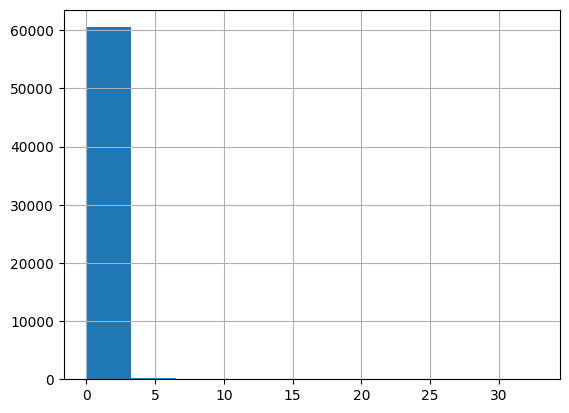

In [6]:
df.RR.hist()
plt.show()

Se evidencia una desproporción en la distribución así que se aplica transformación logarítmica.

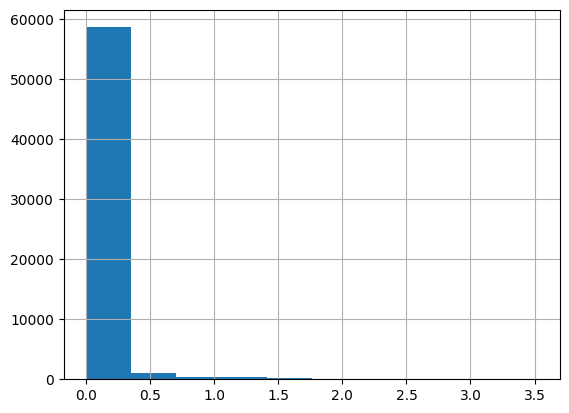

In [7]:
df['RR'] = np.log1p(df['RR'])  # log1p para evitar problemas con ceros
df.RR.hist()
plt.show()

Se convierte la variable target a 0 (si no hay precipitacion: RR <= 0) o si hay precipitación (RR > 0)

In [8]:
df['RR'] = np.where(df.RR<=0.0, 0.0, 1)

In [9]:
df.head()

,FECHA_CORTE,UBIGEO,YY,MM,DY,HH,TT,HR,RR,PP,FF,DD
0,20250530,120904,2018,1,1,0,7.66098,89.51500,1.0,687.40333,2.97943,145.64165
1,20250530,120904,2018,1,1,1,7.73552,90.29500,1.0,686.94167,1.70000,284.01833
2,20250530,120904,2018,1,1,2,7.57108,91.00500,1.0,686.67667,1.65667,63.06462
3,20250530,120904,2018,1,1,3,7.52045,89.73167,0.0,686.50000,1.13227,34.77467
4,20250530,120904,2018,1,1,4,7.13343,88.88167,1.0,686.60333,0.64763,72.41817


Codificación radial para las variables de HH, MM y DY ya que son cíclicas.

In [10]:
# Codificación cíclica para la hora
df['HH_sin'] = np.sin(2 * np.pi * df['HH'] / 24)
df['HH_cos'] = np.cos(2 * np.pi * df['HH'] / 24)

# Para el mes (MM)
df['MM_sin'] = np.sin(2 * np.pi * df['MM'] / 12)
df['MM_cos'] = np.cos(2 * np.pi * df['MM'] / 12)

# Para el día del mes (DY), si sabes que siempre es de 1 a 31
df['DY_sin'] = np.sin(2 * np.pi * df['DY'] / 31)
df['DY_cos'] = np.cos(2 * np.pi * df['DY'] / 31)

df.drop(columns=['HH','MM','DY'])

,FECHA_CORTE,UBIGEO,YY,TT,HR,RR,PP,FF,DD,HH_sin,HH_cos,MM_sin,MM_cos,DY_sin,DY_cos
0,20250530,120904,2018,7.66098,89.51500,1.0,687.40333,2.97943,145.64165,0.000000,1.000000,5.000000e-01,0.866025,2.012985e-01,0.97953
1,20250530,120904,2018,7.73552,90.29500,1.0,686.94167,1.70000,284.01833,0.258819,0.965926,5.000000e-01,0.866025,2.012985e-01,0.97953
2,20250530,120904,2018,7.57108,91.00500,1.0,686.67667,1.65667,63.06462,0.500000,0.866025,5.000000e-01,0.866025,2.012985e-01,0.97953
3,20250530,120904,2018,7.52045,89.73167,0.0,686.50000,1.13227,34.77467,0.707107,0.707107,5.000000e-01,0.866025,2.012985e-01,0.97953
4,20250530,120904,2018,7.13343,88.88167,1.0,686.60333,0.64763,72.41817,0.866025,0.500000,5.000000e-01,0.866025,2.012985e-01,0.97953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61363,20250530,120904,2024,10.27367,83.96833,1.0,685.78500,1.83233,163.55600,-0.965926,0.258819,-2.449294e-16,1.000000,-2.449294e-16,1.00000
61364,20250530,120904,2024,9.81933,86.66000,0.0,686.46333,2.50250,270.63500,-0.866025,0.500000,-2.449294e-16,1.000000,-2.449294e-16,1.00000
61365,20250530,120904,2024,9.39933,83.16717,1.0,687.03000,1.99017,267.03833,-0.707107,0.707107,-2.449294e-16,1.000000,-2.449294e-16,1.00000
61366,20250530,120904,2024,9.40133,79.27250,0.0,687.30000,2.06417,287.48833,-0.500000,0.866025,-2.449294e-16,1.000000,-2.449294e-16,1.00000


Separación de la data en train y test

In [11]:
# separa el dataset en atributos (X)  y  target (y)
df = df.drop(columns=['FECHA_CORTE','UBIGEO','YY'])
array = df.values
X = df.drop(columns='RR')  # atributos
y = df['RR']    # target

# realiza el train-test split
vadid_fraction = 0.20    # proporcion de muestras para validacion
seed = 7   # semilla para el generador aleatorio (para reproductibilidad)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=vadid_fraction, random_state=seed)

print('Training: %d ejemplos. Validation: %d ejemplos' % (len(y_train), len(y_valid)))
######AGREGANDO########
# Random UnderSampler
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# SVMSMOTE
svm_smote = SVMSMOTE(random_state=42)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X_train, y_train)


print("RUS:", X_rus.shape, pd.Series(y_rus).value_counts().to_dict())
print("SVSMOTE:", X_svm_smote.shape, pd.Series(y_svm_smote).value_counts().to_dict())

Training: 48637 ejemplos. Validation: 12160 ejemplos
RUS: (6114, 14) {0.0: 3057, 1.0: 3057}
SVSMOTE: (91160, 14) {0.0: 45580, 1.0: 45580}


Mostrando la distribución de los datos

In [12]:
# muestra la distribucion de las clases
print(df.groupby('RR').size())

RR
0.0    57004
1.0     3793
dtype: int64


## **Evalua diferentes algoritmos de ML en crossvalidacion**
Vamos a evaluar n algoritmos de ML diferentes:

In [13]:
algos = []
algos.append(('LogReg', LogisticRegression( solver='liblinear')))  #genera logistic regresors con solver liblinear
algos.append(('5NN', KNeighborsClassifier( n_neighbors=5))) #genera knn con 5 vecinos
algos.append(('10NN', KNeighborsClassifier( n_neighbors=10))) #genera knn con 5 vecinos
algos.append(('CART', DecisionTreeClassifier(max_depth=None ))) # genera DT sin restriccion de profundidad -> se va hasta el fondo osea overfitting
algos.append(('RF', RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None)))
algos.append(("AdaBoost", AdaBoostClassifier(n_estimators=60 , random_state=seed)))

La evaluacion de cada algoritmo se realiza con los datos de training en estrategia de Crossvalidacion con 10-folds. Se usa el mismo particionamiento de folds en cada algoritmo a evaluar para asegurar una comparación justa.

La metrica de evaluacion es 'balanced_accuracy', esta es el promedio de recalls en cada clase ( recall(clase i) = proporcion correctamente clasificada como clase i del total de ejemplos de clase i ).

In [14]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada algoritmo de ML
for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))    #Esto es el accuracy
######AGREGANDO########
print("\nRUS:")
for algoname, algo in algos:
    cv_results_rus = cross_val_score(algo, X_rus, y_rus, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results_rus)
    names.append(f"{algoname}-RUS")
    print("{}: {} ({})".format(algoname, cv_results_rus.mean(), cv_results_rus.std()))
print("\nSVSMOTE:")
for algoname, algo in algos:
    cv_results_svsmote = cross_val_score(algo, X_svm_smote, y_svm_smote, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results_svsmote)
    names.append(f"{algoname}-SVSMOTE")
    print("{}: {} ({})".format(algoname, cv_results_svsmote.mean(), cv_results_svsmote.std()))

LogReg: 0.5995050638751589 (0.014093603504054919)
5NN: 0.5682502050860615 (0.011344656356601628)
10NN: 0.5296358977701571 (0.005044567981892242)
CART: 0.6561043928054915 (0.012240254699619677)
RF: 0.6244029614664699 (0.010919264409911396)
AdaBoost: 0.5591835174046678 (0.010150327908096692)

RUS:
LogReg: 0.8117698298396279 (0.018398430504287182)
5NN: 0.7654317982567107 (0.018880171131910543)
10NN: 0.7728136762516753 (0.019768894402219888)
CART: 0.7567615136850963 (0.016406206325657886)
RF: 0.8226961115095796 (0.012410770774728477)
AdaBoost: 0.7990564542647361 (0.022083007477354175)

SVSMOTE:
LogReg: 0.8749280659117836 (0.00210293563561856)
5NN: 0.9397026891613217 (0.0025491098263371197)
10NN: 0.9310260689792573 (0.003011803289483805)
CART: 0.9456281057524254 (0.0020367330433016914)
RF: 0.9746474478405842 (0.0012088576201482804)
AdaBoost: 0.9023066862840251 (0.005232896149466005)


Boxplots de algoritmos

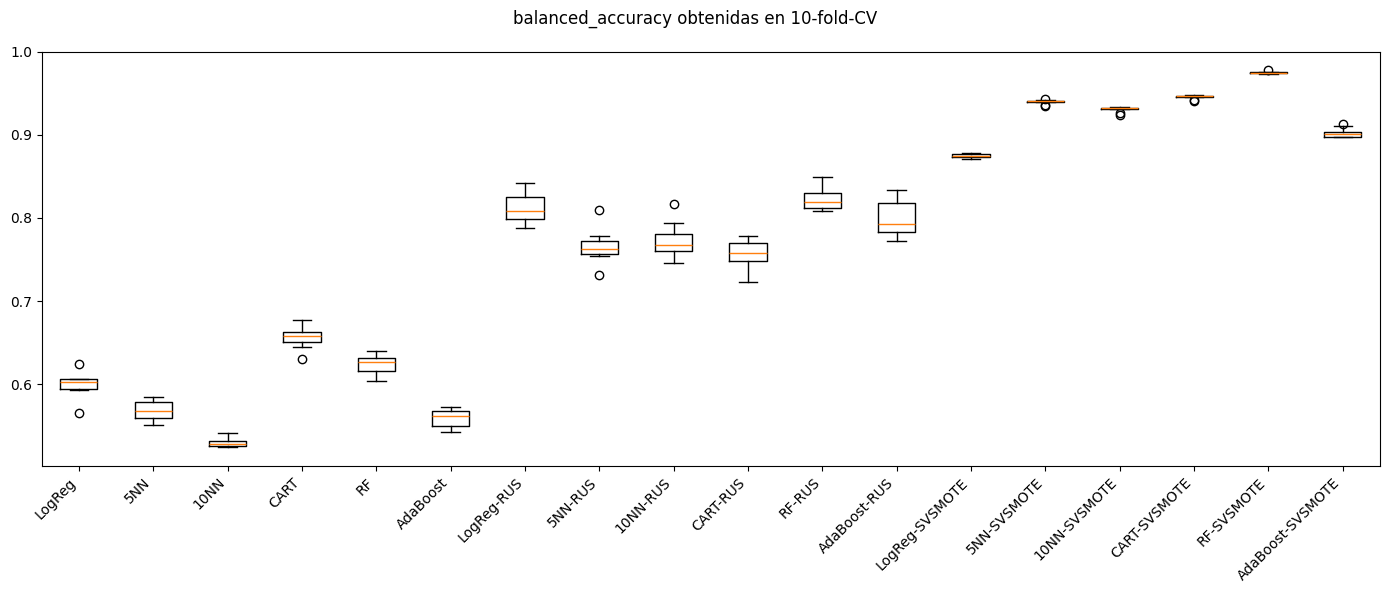

In [17]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 6))
fig.suptitle('balanced_accuracy obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

ENtrenamiento del modelo

In [19]:
# Usamos Random Forest con datos remuestreados con ENN
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None, n_jobs=-1)

# Entrenamos con el conjunto remuestreado con ENN
model.fit(X_svm_smote, y_svm_smote)

# Predecimos en el conjunto de validación original
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# Reporte de clasificación
print("\nReporte de clasificación en conjunto de validacion:\n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.6823639781999756

Matriz de Confusión:
[[11198   226]
 [  453   283]]

Reporte de clasificación en conjunto de validacion:

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     11424
         1.0       0.56      0.38      0.45       736

    accuracy                           0.94     12160
   macro avg       0.76      0.68      0.71     12160
weighted avg       0.94      0.94      0.94     12160

